# ECML/PKDD 15: Taxi Trip Time Prediction (II)

## 簡世育 Allen CHien

# Description of Data

To improve the efficiency of electronic taxi dispatching systems it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request. 

In this challenge, we ask you to build a predictive framework that is able to infer the trip time of taxi rides in Porto, Portugal based on their (initial) partial trajectories. The output of such a framework must be the travel time of a particular taxi trip.

# Aim

建立計程車旅程行駛時間預測模型，方便中央調度。

- [Import package and loading data](#Import package and loading data)
- [Feature description](#Feature description)
- [EDA](#EDA)
    - [duration](#duration)
    - [CALL_TYPE](#CALL_TYPE)
    - [MISSING_DATA](#MISSING_DATA)
    - [CALL_TYPE](#CALL_TYPE)
    - [ORIGIN_CALL](#ORIGIN_CALL)
    - [ORIGIN_STAND](#ORIGIN_STAND)
    - [DAY_TYPE](#DAY_TYPE)
    - [TAXI_ID](#TAXI_ID)
    - [CALL_TYPE](#CALL_TYPE)
    - [TIMESTAMP](#CALL_TYPE)
    - [POLYLINE](#POLYLINE)
        - [K-Mean](#K-Mean)
        - [KNN](#KNN)
- [One hot encoding](#One hot encoding)
- [Bulid Model](#Bulid Model)
    - [Decision tree](#Decision tree)
    - [Random forest](#Random forest)
    - [Gradient boosting Decision Tree](#Gradient boosting Decision Tree)
- [Submit](#Submit)


## Import package and loading data

In [1]:
import numpy as np
import pandas as pd
import json
import time
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')
import sqlite3
conn = sqlite3.connect('TT.db')
from sklearn.cluster import KMeans

In [2]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Feature description

In [3]:
print('train_shape:', train.shape, 'test_shape', test.shape)

train_shape: (1710670, 9) test_shape (320, 9)


In [4]:
train.head(3)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,nan,nan,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,nan,7.00,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,nan,nan,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."


 - TRIP_ID : 旅程程編號(String)
 - CALL_TYPE : 三種叫車方式(char)，A - 乘客叫車由中心指派 ；B - 乘客叫車指定司機；C - 路邊攔車
 - ORIGIN_CALL : 當CALL_TYPE為A，表示乘客叫車的電話號碼(integer)
 - ORIGIN_STAND : 當CALL_TYPE為B，表示計程車接客地點(integer)
 - TAXI_ID : 計程車編號(integer)
 - TIMESTAMP : 時間戳(integer)
 - DAYTYPE : 三種叫車方式(char)，A - 平日或假日；B - 特殊假期；C - 特殊假期B前一天
 - MISSING_DATA : GPS 沒記錄到的旅程(Boolean)
 - POLYLINE : WGS84座標[ 經度 ，緯度 ]表示，(String)，每15秒記錄一次座標

## EDA

### duration

In [5]:
#將POLYLINE轉換為時間
train['POLYLINE_List'] = train['POLYLINE'].apply(json.loads)
train['duration'] = ((train['POLYLINE_List'].apply(len))-1)*15

In [8]:
train = train.drop('POLYLINE_List', axis = 1)

In [10]:
#存到SQLite
train.to_sql("Taxi_train", conn, if_exists= "replace")

In [10]:
#train_duration['Z_s'] = train_duration['duration'].apply(lambda x:(x - np.mean(train_duration['duration']))/np.std(train_duration['duration']))

In [11]:
query_str = """
    SELECT * FROM Taxi_train;
"""
train = pd.read_sql_query(query_str, conn)

In [12]:
train.head()

,index,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,duration
0,0,1372636858620000589,C,nan,nan,20000589,1372636858,A,0,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330
1,1,1372637303620000596,B,nan,7.00,20000596,1372637303,A,0,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270
2,2,1372636951620000320,C,nan,nan,20000320,1372636951,A,0,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960
3,3,1372636854620000520,C,nan,nan,20000520,1372636854,A,0,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630
4,4,1372637091620000337,C,nan,nan,20000337,1372637091,A,0,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420


In [13]:
train['duration'].describe()

count   1710670.00
mean        716.37
std         684.81
min         -15.00
25%         405.00
50%         600.00
75%         870.00
max       58200.00
Name: duration, dtype: float64

In [14]:
#刪除duration = -15，共5901筆
print(train.shape)
print(train[train['duration'] == -15].shape)
train = train[train['duration'] != -15]
print(train.shape)

(1710670, 11)
(5901, 11)
(1704769, 11)


刪除duration為-15的資料

In [15]:
q75, q25 = np.percentile(train.duration, [75 ,25])

In [16]:
iqr = q75 - q25 
duration_min = q25 - (iqr*1.5)
duration_max = q75 + (iqr*1.5)

min: -292.5 max: 1567.5


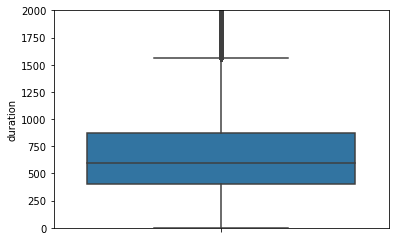

In [17]:
fig = sns.boxplot(y='duration', data=train)
fig.axis(ymin=0, ymax=2000)
print('min:', duration_min, 'max:', duration_max)

將duration大於1567以上的設為outlier並刪除

In [18]:
print(train.shape)
train = train[train['duration'] < 1567]
print(train.shape)

(1704769, 11)
(1625992, 11)


(-50, 2000, 0.0, 0.0018936073391599625)

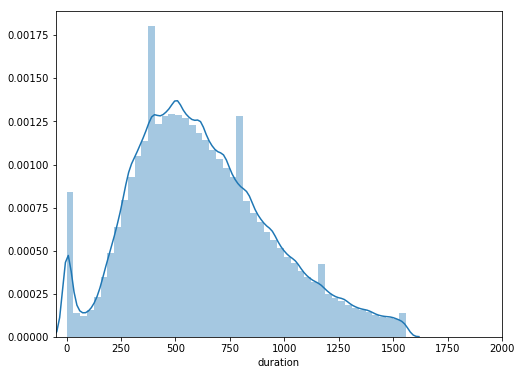

In [19]:
plt.subplots(figsize=(8, 6))
fig = sns.distplot(train.duration)
fig.axis(xmin=-50, xmax=2000)

### CALL_TYPE

In [20]:
train.CALL_TYPE.unique()

array(['C', 'B', 'A'], dtype=object)

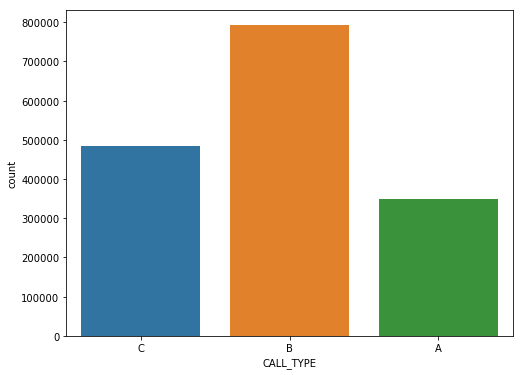

In [21]:
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(train['CALL_TYPE'])

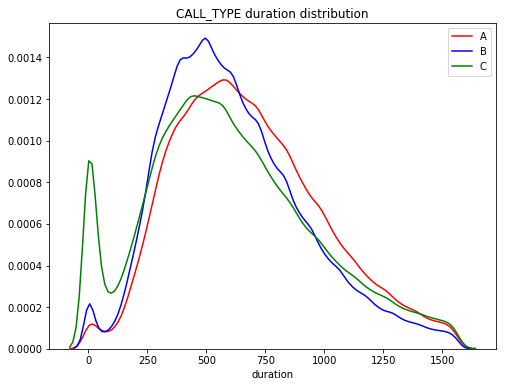

In [22]:
fig, axes = plt.subplots(1,figsize=(8, 6))
axes.set_title('CALL_TYPE duration distribution')
k1 = sns.distplot(train[train['CALL_TYPE'] == 'A'].duration, hist=False, color='r', label='A')
k2 = sns.distplot(train[train['CALL_TYPE'] == 'B'].duration, hist=False, color='b', label='B')
k2 = sns.distplot(train[train['CALL_TYPE'] == 'C'].duration, hist=False, color='g', label='C')
ax.legend(fontsize=15)

(-0.5, 2.5, 0, 2000)

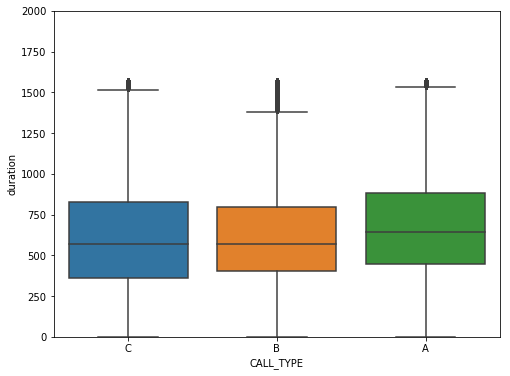

In [23]:
data = pd.concat([train['duration'], train['CALL_TYPE']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='CALL_TYPE', y='duration', data=data)
fig.axis(ymin=0, ymax=2000)

### MISSING_DATA

In [24]:
train.shape

(1625992, 11)

In [25]:
train = train[train['MISSING_DATA'] == False ]

In [26]:
train.shape

(1625984, 11)

In [27]:
train = train.drop('MISSING_DATA', axis=1)

訓練資料中只有10筆MISSING_DATA，因比例不大，給予刪除

## ORIGIN_CALL

In [28]:
train['ORIGIN_CALL'].unique().shape

(55622,)

## ORIGIN_STAND

In [29]:
train['ORIGIN_STAND'].unique().shape

(64,)

## DAY_TYPE

In [30]:
train['DAY_TYPE'].unique()

array(['A'], dtype=object)

In [31]:
train = train.drop(['ORIGIN_CALL', 'ORIGIN_STAND', 'DAY_TYPE'], axis = 1)

In [33]:
train.to_sql("Taxi_train_1", conn, if_exists= "replace")

In [34]:
query_str = """
    SELECT * FROM Taxi_train_1;
"""
train = pd.read_sql_query(query_str, conn)

In [36]:
train = train.reindex(fill_value=0)

In [38]:
test_ID = set(test.TAXI_ID.unique())
train_ID = set(train.TAXI_ID.unique())

In [39]:
train = train[train['TAXI_ID'] != 20000257]

In [40]:
train = train.drop(['level_0', 'index'], axis = 1)

In [41]:
train.to_sql("Taxi_train_2", conn, if_exists= "replace")

In [19]:
1+1 

2

In [20]:
query_str = """
    SELECT * FROM Taxi_train_2;
"""
train = pd.read_sql_query(query_str, conn)

In [21]:
train.head()

,index,TRIP_ID,CALL_TYPE,TAXI_ID,TIMESTAMP,POLYLINE,duration
0,0,1372636858620000589,C,20000589,1372636858,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330
1,1,1372637303620000596,B,20000596,1372637303,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270
2,2,1372636951620000320,C,20000320,1372636951,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960
3,6,1372637210620000456,C,20000456,1372637210,"[[-8.57952,41.145948],[-8.580942,41.145039],[-...",525
4,8,1372637274620000403,C,20000403,1372637274,"[[-8.611794,41.140557],[-8.611785,41.140575],[...",555


### TAXI_ID

In [22]:
data = pd.concat([train['TAXI_ID'], train['duration']], axis=1)

In [23]:
TAXI_ID_duration = pd.pivot_table(data, columns='TAXI_ID')
TAXI_ID_duration_T = TAXI_ID_duration.T.sort_values(by = 'duration', ascending=False)
TAXI_ID_duration_T.describe()

,duration
count,244.00
mean,640.10
std,50.18
min,427.27
25%,611.91
50%,637.31
75%,670.00
max,805.63


In [24]:
type_1, type_2, type_3 =[], [], []
TAXI_ID_cluster = {}

for i in TAXI_ID_duration.columns:
    if TAXI_ID_duration[i][0]>670:
        type_1.append(i)
    elif TAXI_ID_duration[i][0]<670 and TAXI_ID_duration[i][0]>611.91:
        type_2.append(i)
    else:
        type_3.append(i)
    TAXI_ID_cluster = {1 : type_1, 2:type_2, 3:type_3}

In [46]:
for i in range(tt.shape[0]):
    if tt.TAXI_ID[i] in TAXI_ID_cluster[1]:
        tt.TAXI_ID[i] = 1
    elif tt.TAXI_ID[i] in TAXI_ID_cluster[2]:
        tt.TAXI_ID[i] = 2
    else:
        tt.TAXI_ID[i] = 3

In [50]:
for i in range(test.shape[0]):
    if test.TAXI_ID[i] in TAXI_ID_cluster[1]:
        test.TAXI_ID[i] = 1
    elif test.TAXI_ID[i] in TAXI_ID_cluster[2]:
        test.TAXI_ID[i] = 2
    else:
        test.TAXI_ID[i] = 3

In [45]:
train.to_sql("Taxi_train_3", conn, if_exists= "replace")
test.to_sql("Taxi_test_3", conn, if_exists= "replace")

In [56]:
train['index'] = train.index

### TIMESTAMP

In [104]:
year = []
hour = []
day_of_month = []
month = []
weekday = []
for i in range(train.shape[0]):
    year.append(datetime.datetime.fromtimestamp(train['TIMESTAMP'][i]).strftime('%Y-%m-%d'))#year
    hour.append(datetime.datetime.fromtimestamp(train['TIMESTAMP'][i]).strftime('%H'))#Hour (24-hour clock)
    day_of_month.append(datetime.datetime.fromtimestamp(train['TIMESTAMP'][i]).strftime('%d'))#Day of the month
    month.append(datetime.datetime.fromtimestamp(train['TIMESTAMP'][i]).strftime('%m'))#Month
    weekday.append(datetime.datetime.fromtimestamp(train['TIMESTAMP'][i]).strftime('%A'))#weekday
train['year'] = year
train['hour'] = hour
train['month'] = month
train['day_of_month'] = day_of_month
train['weekday'] = weekday

In [107]:
train

,index,TRIP_ID,CALL_TYPE,TAXI_ID,TIMESTAMP,POLYLINE,duration,date_H,date_D,date_M,date_W,date_Y,year,hour,day_of_month,month,weekday
0,0,1372636858620000589,C,2,1372636858,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,08,01,07,Monday,2013,2013-07-01,08,01,07,Monday
1,1,1372637303620000596,B,2,1372637303,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,08,01,07,Monday,2013,2013-07-01,08,01,07,Monday
2,2,1372636951620000320,C,2,1372636951,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,08,01,07,Monday,2013,2013-07-01,08,01,07,Monday
3,3,1372637210620000456,C,2,1372637210,"[[-8.57952,41.145948],[-8.580942,41.145039],[-...",525,08,01,07,Monday,2013,2013-07-01,08,01,07,Monday
4,4,1372637274620000403,C,3,1372637274,"[[-8.611794,41.140557],[-8.611785,41.140575],[...",555,08,01,07,Monday,2013,2013-07-01,08,01,07,Monday


In [105]:
def time_slicer(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,12])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i],color=color)
        ax[i].set_ylabel(value.replace("_", " ").title())
        ax[i].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i].set_xlabel("")
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)

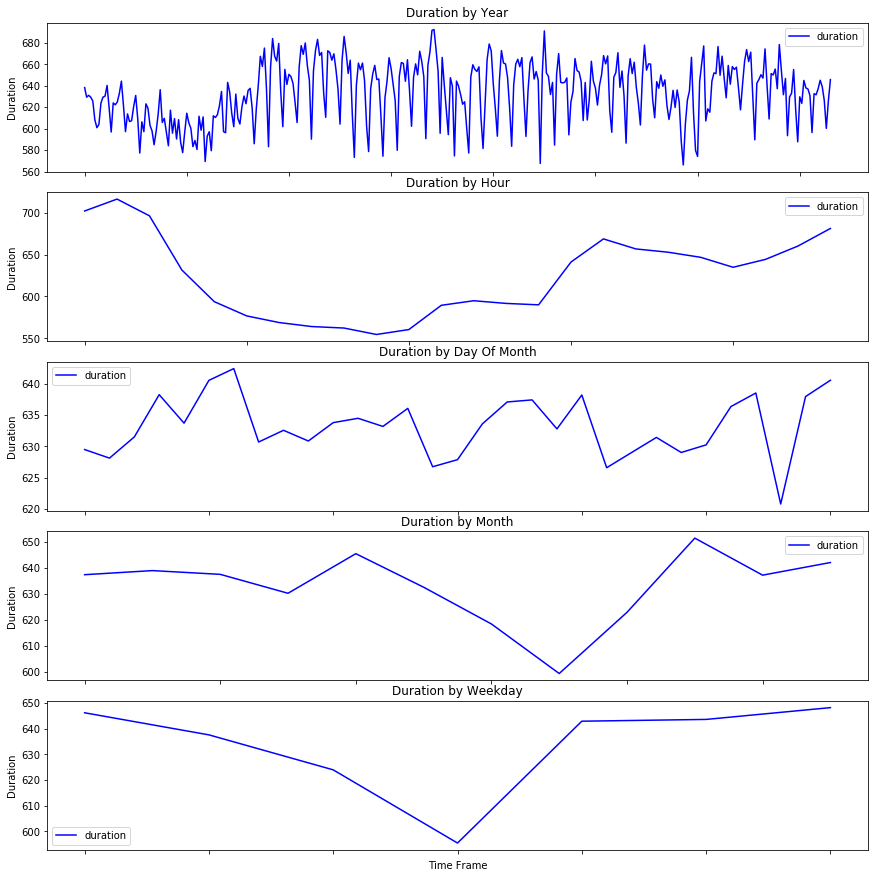

In [106]:
time_slicer(df=train, timeframes=['year',"hour", "day_of_month", "month", "weekday"], value = "duration", color="blue")

In [108]:
train = train.loc[:,['TRIP_ID', 'CALL_TYPE', 'TAXI_ID','hour', 'day_of_month', 'month', 'weekday' , 'POLYLINE', 'duration']]

In [116]:
year = []
hour = []
day_of_month = []
month = []
weekday = []
for i in range(test.shape[0]):
    #year.append(datetime.datetime.fromtimestamp(test['TIMESTAMP'][i]).strftime('%Y-%m-%d'))#year
    hour.append(datetime.datetime.fromtimestamp(test['TIMESTAMP'][i]).strftime('%H'))#Hour (24-hour clock)
    day_of_month.append(datetime.datetime.fromtimestamp(test['TIMESTAMP'][i]).strftime('%d'))#Day of the month
    month.append(datetime.datetime.fromtimestamp(test['TIMESTAMP'][i]).strftime('%m'))#Month
    weekday.append(datetime.datetime.fromtimestamp(test['TIMESTAMP'][i]).strftime('%A'))#weekday
#test['year'] = year
test['hour'] = hour
test['month'] = month
test['day_of_month'] = day_of_month
test['weekday'] = weekday

In [119]:
test = test.loc[:,['TRIP_ID', 'CALL_TYPE', 'TAXI_ID','hour', 'day_of_month', 'month', 'weekday' , 'POLYLINE']]

In [120]:
test.head(2)

,TRIP_ID,CALL_TYPE,TAXI_ID,hour,day_of_month,month,weekday,POLYLINE
0,T1,B,2,01,15,08,Friday,"[[-8.585676,41.148522],[-8.585712,41.148639],[..."
1,T2,B,2,01,15,08,Friday,"[[-8.610876,41.14557],[-8.610858,41.145579],[-..."


In [121]:
train.head(2)

,TRIP_ID,CALL_TYPE,TAXI_ID,hour,day_of_month,month,weekday,POLYLINE,duration
0,1372636858620000589,C,2,08,01,07,Monday,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330
1,1372637303620000596,B,2,08,01,07,Monday,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270


In [122]:
train.to_sql("Taxi_train_4", conn, if_exists= "replace")
test.to_sql("Taxi_test_4", conn, if_exists= "replace")

In [131]:
query_strTR4 = """
    SELECT * FROM Taxi_train_4;
"""
train = pd.read_sql_query(query_strTR4, conn)

query_strTE4 = """
    SELECT * FROM Taxi_test_4;
"""
test = pd.read_sql_query(query_strTE4, conn)

### POLYLINE

In [132]:
train['POLYLINE'] = train['POLYLINE'].apply(json.loads)
test['POLYLINE'] = test['POLYLINE'].apply(json.loads)

In [133]:
test['duration'] = ((test['POLYLINE'].apply(len))-1)*15

In [135]:
testdd = test888[['duration']]

In [6]:
def S_D(df):
    start = []
    destination = []
    for i in range(df.shape[0]):
        start.append(df['POLYLINE'][i][0])
        destination.append(df['POLYLINE'][i][-1])
    df['start'] = start
    df['destination'] = destination

In [7]:
S_D(train)
S_D(test)

In [8]:
test_means = pd.DataFrame()
start_X = []
start_Y = []
destination_X = [] 
destination_Y = []
for i in range(test.shape[0]):
    start_X.append(test.start[i][0])
    start_Y.append(test.start[i][1])
    destination_X.append(test.destination[i][0])
    destination_Y.append(test.destination[i][1])
test_means['start_X'] = start_X
test_means['start_Y'] = start_Y
test_means['destination_X'] = destination_X
test_means['destination_Y'] = destination_Y

In [9]:
train_means = pd.DataFrame()
start_X = []
start_Y = []
destination_X = [] 
destination_Y = []
for i in range(train.shape[0]):
    start_X.append(train.start[i][0])
    start_Y.append(train.start[i][1])
    destination_X.append(train.destination[i][0])
    destination_Y.append(train.destination[i][1])
train_means['start_X'] = start_X
train_means['start_Y'] = start_Y
train_means['destination_X'] = destination_X
train_means['destination_Y'] = destination_Y

In [10]:
train_id = train[['TRIP_ID']]
test_id = test[['TRIP_ID']]

In [11]:
train_means = pd.concat([train_id, train_means], axis = 1)
test_means = pd.concat([test_id, test_means], axis = 1)

In [12]:
XXX = start_X + destination_X
YYY = start_Y + destination_Y

In [13]:
iii = pd.DataFrame()
iii['X'] = XXX
iii['Y'] = YYY
iii.shape

(1906334, 2)

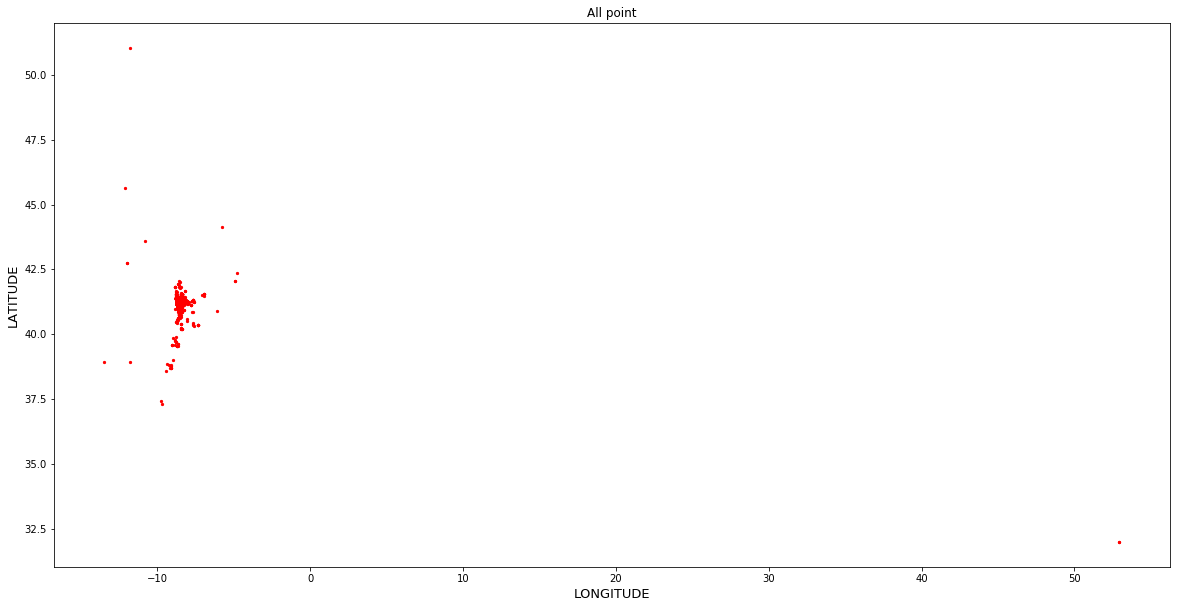

In [14]:
plt.figure(figsize=(20,10))
plt.scatter(iii.X, iii.Y,s = 5, c= 'r')
plt.title('All point')
plt.xlabel('LONGITUDE', fontsize = 13)
plt.ylabel('LATITUDE', fontsize = 13)
plt.show()

In [15]:
low = .05
high = .95
quant_iii = iii.quantile([low, high])

In [16]:
filt_iii = iii.apply(lambda x: x[(x>quant_iii.loc[low,x.name]) &  (x < quant_iii.loc[high,x.name])], axis=0)
good_iii = filt_iii.dropna()
good_iii.shape

(1559147, 2)

#### K-Mean

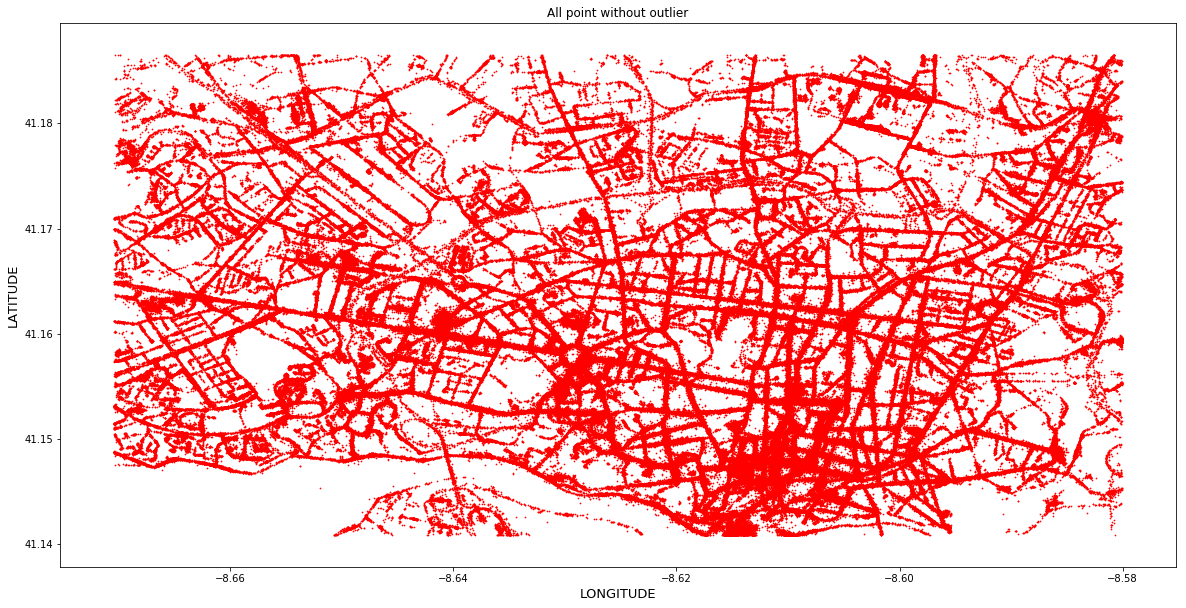

In [17]:
plt.figure(figsize=(20,10))
plt.scatter(good_iii.X, good_iii.Y, c= 'r', s = 0.5)
plt.title('All point without outlier')
plt.xlabel('LONGITUDE', fontsize = 13)
plt.ylabel('LATITUDE', fontsize = 13)
plt.show()

In [18]:
Xs = good_iii.iloc[:, 0:3].values
len(Xs)

1559147

In [19]:
kmeans = KMeans(n_clusters = 11, max_iter = 300, n_init = 10, init = 'k-means++', random_state = 889)

In [20]:
y_kmeans = kmeans.fit_predict(Xs)
len(y_kmeans)

1559147

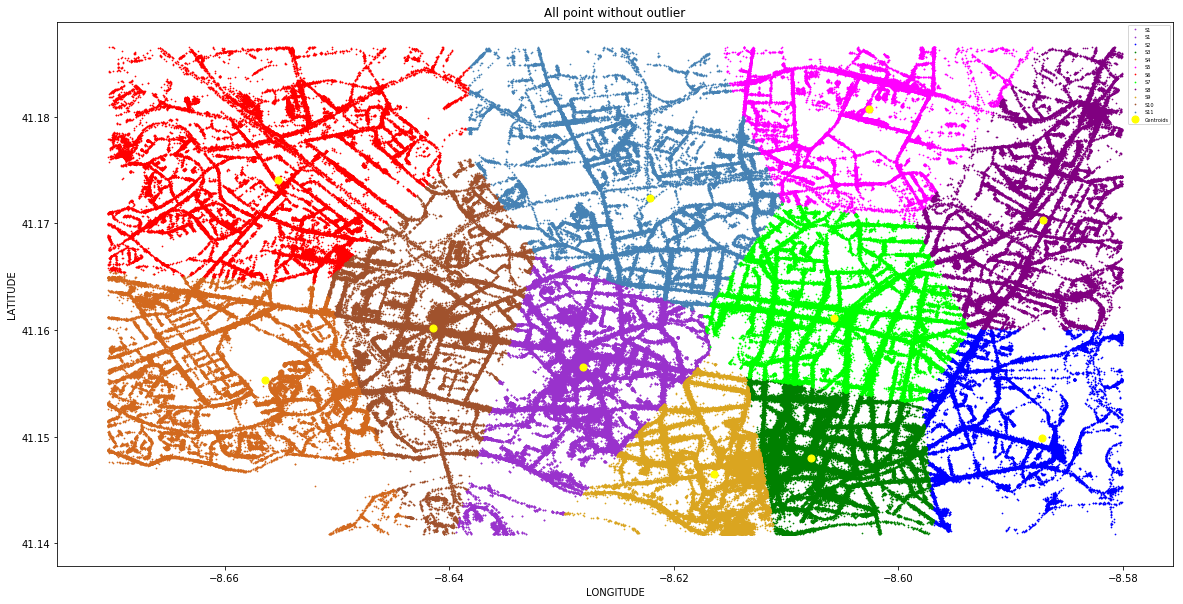

In [21]:
plt.figure(figsize=(20,10))
plt.scatter(Xs[y_kmeans == 0, 0], Xs[y_kmeans == 0, 1],s = 0.5, c = 'darkorchid', label = 'S1')
plt.scatter(Xs[y_kmeans == 0, 0], Xs[y_kmeans == 0, 1],s = 0.5, c = 'darkorchid', label = 'S1')
plt.scatter(Xs[y_kmeans == 1, 0], Xs[y_kmeans == 1, 1],s = 0.5, c = 'blue', label = 'S2')
plt.scatter(Xs[y_kmeans == 2, 0], Xs[y_kmeans == 2, 1],s = 0.5, c = 'green', label = 'S3')
plt.scatter(Xs[y_kmeans == 3, 0], Xs[y_kmeans == 3, 1],s = 0.5, c = 'chocolate', label = 'S4')
plt.scatter(Xs[y_kmeans == 4, 0], Xs[y_kmeans == 4, 1],s = 0.5, c = 'magenta', label = 'S5')
plt.scatter(Xs[y_kmeans == 5, 0], Xs[y_kmeans == 5, 1],s = 0.5, c = 'red', label = 'S6')
plt.scatter(Xs[y_kmeans == 6, 0], Xs[y_kmeans == 6, 1],s = 0.5, c = 'lime', label = 'S7')
plt.scatter(Xs[y_kmeans == 7, 0], Xs[y_kmeans == 7, 1],s = 0.5, c = 'purple', label = 'S8')
plt.scatter(Xs[y_kmeans == 8, 0], Xs[y_kmeans == 8, 1],s = 0.5, c = 'goldenrod', label = 'S9')
plt.scatter(Xs[y_kmeans == 9, 0], Xs[y_kmeans == 9, 1],s = 0.5, c = 'sienna', label = 'S10')
plt.scatter(Xs[y_kmeans == 10, 0], Xs[y_kmeans == 10, 1],s = 0.5, c = 'steelblue', label = 'S11')
plt.scatter(kmeans.cluster_centers_[:, 0],  kmeans.cluster_centers_[:, 1], s = 50, c = 'yellow', label = 'Centroids')
plt.title('All point without outlier')
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.legend(fontsize=5, loc = 1)
plt.show()

In [22]:
print(good_iii.shape)
print(len(y_kmeans))

(1559147, 2)
1559147


In [23]:
good_iii['K'] = y_kmeans 
good_iii.head()

,X,Y,K
0,-8.62,41.14,8
1,-8.64,41.16,9
6,-8.59,41.16,7
7,-8.58,41.16,7
8,-8.60,41.15,2


#### KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [25]:
X = good_iii.iloc[:,0:2].values
y = good_iii.iloc[:,-1:].values

In [26]:
train_data , test_data , train_label , test_label = train_test_split(X,y,test_size=0.2)

In [27]:
knn = KNeighborsClassifier()
knn.fit(train_data,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [28]:
print(knn.predict(test_data))

[6 0 6 ... 7 5 7]


In [29]:
print(train_means.shape)
print(test_means.shape)

(953167, 5)
(320, 5)


In [30]:
train_start = train_means[['TRIP_ID', 'start_X', 'start_Y']]
train_destination = train_means[['TRIP_ID', 'destination_X', 'destination_Y']]
test_start = test_means[['TRIP_ID', 'start_X', 'start_Y']]
test_destination = test_means[['TRIP_ID', 'destination_X', 'destination_Y']]

In [31]:
print('train_start', train_start.shape)
print('train_destination', train_destination.shape)
print('test_start', test_start.shape)
print('test_destination', test_destination.shape)

train_start (953167, 3)
train_destination (953167, 3)
test_start (320, 3)
test_destination (320, 3)


In [32]:
trainS = train_start.iloc[:, 1:3].values
trainD = train_destination.iloc[:, 1:3].values
testS = test_start.iloc[:, 1:3].values
testD = test_destination.iloc[:, 1:3].values

In [33]:
test_start['start point'] = knn.predict(testS)
test_destination['destination point'] = knn.predict(testD)
test_destination = test_destination.drop('TRIP_ID', axis = 1)

In [34]:
train_start['start point'] = knn.predict(trainS)
train_destination['destination point'] = knn.predict(trainD)
train_destination = train_destination.drop('TRIP_ID', axis = 1)

In [35]:
train_k = pd.concat([train_start, train_destination], axis = 1)
test_k = pd.concat([test_start, test_destination], axis = 1)

In [36]:
train.head(2)

,index,TRIP_ID,CALL_TYPE,TAXI_ID,hour,day_of_month,month,weekday,POLYLINE,duration,start,destination
0,0,1372636858620000589,C,2,08,01,07,Monday,"[[-8.618643, 41.141412], [-8.618499, 41.141376...",330,"[-8.618643, 41.141412]","[-8.630838, 41.154489]"
1,1,1372637303620000596,B,2,08,01,07,Monday,"[[-8.639847, 41.159826], [-8.640351, 41.159871...",270,"[-8.639847, 41.159826]","[-8.66574, 41.170671]"


In [37]:
train['start'] = train_k['start point']
train['destination'] = train_k['destination point']
test['start'] = test_k['start point']
test['destination'] = test_k['destination point']

In [38]:
train.head()

,index,TRIP_ID,CALL_TYPE,TAXI_ID,hour,day_of_month,month,weekday,POLYLINE,duration,start,destination
0,0,1372636858620000589,C,2,08,01,07,Monday,"[[-8.618643, 41.141412], [-8.618499, 41.141376...",330,8,0
1,1,1372637303620000596,B,2,08,01,07,Monday,"[[-8.639847, 41.159826], [-8.640351, 41.159871...",270,9,5
2,2,1372636951620000320,C,2,08,01,07,Monday,"[[-8.612964, 41.140359], [-8.613378, 41.14035]...",960,8,8
3,3,1372637210620000456,C,2,08,01,07,Monday,"[[-8.57952, 41.145948], [-8.580942, 41.145039]...",525,1,2
4,4,1372637274620000403,C,3,08,01,07,Monday,"[[-8.611794, 41.140557], [-8.611785, 41.140575...",555,8,7


In [39]:
test.head()

,index,TRIP_ID,CALL_TYPE,TAXI_ID,hour,day_of_month,month,weekday,POLYLINE,start,destination
0,0,T1,B,2,01,15,08,Friday,"[[-8.585676, 41.148522], [-8.585712, 41.148639...",1,1
1,1,T2,B,2,01,15,08,Friday,"[[-8.610876, 41.14557], [-8.610858, 41.145579]...",2,6
2,2,T3,B,3,01,15,08,Friday,"[[-8.585739, 41.148558], [-8.58573, 41.148828]...",1,7
3,3,T4,B,3,01,15,08,Friday,"[[-8.613963, 41.141169], [-8.614125, 41.141124...",8,8
4,4,T5,B,3,01,15,08,Friday,"[[-8.619903, 41.148036], [-8.619894, 41.148036]]",8,8


In [46]:
train = train.loc[:,['CALL_TYPE', 'TAXI_ID', 'hour', 'day_of_month', 'month', 'weekday' ,'start', 'destination','duration']]
test = test.loc[:,['TRIP_ID', 'CALL_TYPE', 'TAXI_ID', 'hour', 'day_of_month', 'month', 'weekday' ,'start','destination']]

In [56]:
test.head(2)

,TRIP_ID,CALL_TYPE,TAXI_ID,hour,day_of_month,month,weekday,start,destination
0,T1,B,2,01,15,08,Friday,1,1
1,T2,B,2,01,15,08,Friday,2,6


In [55]:
train.head(2)

,CALL_TYPE,TAXI_ID,hour,day_of_month,month,weekday,start,destination,duration
0,C,2,08,01,07,Monday,8,0,330
1,B,2,08,01,07,Monday,9,5,270


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953167 entries, 0 to 953166
Data columns (total 9 columns):
CALL_TYPE       953167 non-null object
TAXI_ID         953167 non-null int64
hour            953167 non-null object
day_of_month    953167 non-null object
month           953167 non-null object
weekday         953167 non-null object
start           953167 non-null int32
destination     953167 non-null int32
duration        953167 non-null int64
dtypes: int32(2), int64(2), object(5)
memory usage: 58.2+ MB


In [54]:
train.to_sql("Taxi_train_5", conn, if_exists= "replace")
test.to_sql("Taxi_test_5", conn, if_exists= "replace")

In [116]:
query_strTR4 = """
    SELECT * FROM Taxi_train_5;
"""
train = pd.read_sql_query(query_strTR4, conn)

query_strTE4 = """
    SELECT * FROM Taxi_test_5;
"""
test = pd.read_sql_query(query_strTE4, conn)

## One hot encoding

In [117]:
train[['hour', 'day_of_month', 'month']] = train[['hour', 'day_of_month', 'month']].astype(int)
test[['hour', 'day_of_month', 'month']] = test[['hour', 'day_of_month', 'month']].astype(int)

In [118]:
train.weekday.unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [119]:
train['weekday'] = train['weekday'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'], [0, 1, 2, 3, 4, 5, 6])
test['weekday'] = test['weekday'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'], [0, 1, 2, 3, 4, 5, 6])

In [120]:
train_dummy = pd.get_dummies( train.CALL_TYPE , prefix='CALL_TYPE' )
test_dummy = pd.get_dummies( test.CALL_TYPE , prefix='CALL_TYPE' )

In [121]:
train = pd.concat([train, train_dummy],axis=1)
test = pd.concat([test, test_dummy],axis=1)

In [122]:
train = train.loc[:,['CALL_TYPE_A','CALL_TYPE_B', 'CALL_TYPE_C',  'TAXI_ID', 'hour', 'day_of_month', 'month', 'weekday' ,'start', 'destination','duration']]
test = test.loc[:,['TRIP_ID', 'CALL_TYPE_A','CALL_TYPE_B', 'CALL_TYPE_C', 'TAXI_ID', 'hour', 'day_of_month', 'month', 'weekday' ,'start','destination']]

In [136]:
test = pd.concat([test, testdd], axis = 1)

In [127]:
train.head(2)

,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,TAXI_ID,hour,day_of_month,month,weekday,start,destination,duration
0,0,0,1,2,8,1,7,0,8,0,330
1,0,1,0,2,8,1,7,0,9,5,270


In [137]:
test.head(2)

,TRIP_ID,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,TAXI_ID,hour,day_of_month,month,weekday,start,destination,duration
0,T1,0,1,0,2,1,15,8,4,1,1,150
1,T2,0,1,0,2,1,15,8,4,2,6,585


In [138]:
train.to_sql("Taxi_train_F", conn, if_exists= "replace")
test.to_sql("Taxi_test_F", conn, if_exists= "replace")

In [3]:
query_strTR4 = """
    SELECT * FROM Taxi_train_F;
"""
train = pd.read_sql_query(query_strTR4, conn)

query_strTE4 = """
    SELECT * FROM Taxi_test_F;
"""
test = pd.read_sql_query(query_strTE4, conn)

## Bulid Model

In [72]:
from sklearn.preprocessing  import StandardScaler
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error,r2_score, mean_squared_log_error, mean_absolute_error, mean_squared_log_error
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore")

In [76]:
X = train.iloc[:, 0:-1].values
Y = train.loc[:,['duration']].values
vaild_X = test.iloc[:, 2:-1].values
vaild_Y = test.loc[:,['duration']].values

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 889)

### Decision tree

In [80]:
params={'max_features':[x for x in range(3,9,2)], 
        'min_samples_split':[x for x in range(2,10,2)],
        'min_samples_leaf':[x for x in range(2,10,2)],
        }

In [81]:
clf = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', max_depth = None, random_state=889)

In [82]:
grid = GridSearchCV(clf, params, cv=10, scoring="neg_mean_squared_log_error")
grid.fit(X_train, y_train)

grid.best_params_

{'max_features': 7, 'min_samples_leaf': 6, 'min_samples_split': 2}

In [84]:
DTR = DecisionTreeRegressor(criterion = 'mse', splitter = 'random',
                            max_depth = None, random_state = 889, max_leaf_nodes = 20,
                            max_features = 7, min_samples_leaf = 6, min_samples_split = 2)
DTR.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=7,
           max_leaf_nodes=20, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=889, splitter='random')

In [85]:
DTR_predict=DTR.predict(X_test)
rmsle(DTR_predict, y_test)

0.68376830837292

### Random forest

In [86]:
params={'max_features':[x for x in range(3,9,2)], 
        'min_samples_leaf':[x for x in range(2,10,2)],
        'max_leaf_nodes':[x for x in range(10,100,10)],
        'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5]
        }

In [87]:
RFR = RandomForestRegressor(criterion = 'mse', max_depth = None, random_state=889)

In [88]:
grid = GridSearchCV(RFR, params, cv=10, scoring="neg_mean_squared_log_error")
grid.fit(X_train, y_train)

grid.best_params_

{'max_features': 7,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 2,
 'min_weight_fraction_leaf': 0.1}

In [89]:
RFR = RandomForestRegressor(criterion = 'mse', min_weight_fraction_leaf =0.1, 
                            random_state=889, max_depth = None, n_estimators=2500
                            max_features = 7, min_samples_leaf = 2, max_leaf_nodes = 10
)
RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.1,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=889,
           verbose=0, warm_start=False)

In [90]:
RFR_predict=RFR.predict(X_test)
rmsle(RFR_predict, y_test)

0.6156555521965246

### Gradient boosting Decision Tree 

In [91]:
params={'min_samples_split':[x for x in range(2,10,2)],
        'max_features':[x for x in range(3,9,2)],
        'min_samples_leaf':[x for x in range(1,11,2)]
        }

In [92]:
GBDT = GradientBoostingRegressor(n_estimators=10)
grid = GridSearchCV(GBDT, params, cv=10, scoring="neg_mean_squared_log_error")
grid.fit(X_train, y_train)

grid.best_params_

{'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 8}

In [93]:
GBDT = GradientBoostingRegressor(loss='lad',alpha = 0.9 ,random_state=889, n_estimators=100, learning_rate = 0.1, max_depth = 3)
GBDT.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=889,
             subsample=1.0, verbose=0, warm_start=False)

In [94]:
GBDT_predict=GBDT.predict(X_test)
rmsle(GBDT_predict, y_test)

0.5700637528757221

## Submit

In [97]:
submit = pd.read_csv('sampleSubmission.csv')

In [98]:
GBDT_predict=GBDT.predict(vaild_X)

In [99]:
submit['TRAVEL_TIME'] = GBDT_predict

In [100]:
submit.head()

,TRIP_ID,TRAVEL_TIME
0,T1,706.26
1,T2,639.23
2,T3,589.86
3,T4,586.43
4,T5,586.43
